# Ridge Regression Analysis - WIN PREDICTION

## IMPORTING DATA & LIBRARIES

In [26]:
# nba data
from nba_api.stats.endpoints import teamestimatedmetrics

# data manipulation/visualization packages
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import json

# scikit
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier,DummyRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer


In [2]:
# get team data
team_stats = teamestimatedmetrics.TeamEstimatedMetrics(
     season='2022-23'
    ).get_data_frames()[0][:30]

In [3]:
team_stats

,TEAM_NAME,TEAM_ID,GP,W,L,W_PCT,MIN,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,...,MIN_RANK,E_OFF_RATING_RANK,E_DEF_RATING_RANK,E_NET_RATING_RANK,E_AST_RATIO_RANK,E_OREB_PCT_RANK,E_DREB_PCT_RANK,E_REB_PCT_RANK,E_TM_TOV_PCT_RANK,E_PACE_RANK
0,Golden State Warriors,1610612744,82,44,38,0.537,3966.0,113.5,111.4,2.1,...,12,9,12,10,2,14,16,10,29,1
1,San Antonio Spurs,1610612759,82,22,60,0.268,3971.0,107.2,117.7,-10.5,...,8,29,30,30,8,7,24,21,24,2
2,Indiana Pacers,1610612754,82,35,47,0.427,3951.0,111.0,115.4,-4.4,...,25,24,26,26,7,18,30,28,20,3
3,Memphis Grizzlies,1610612763,82,51,31,0.622,3956.0,112.3,108.3,4.0,...,22,14,2,4,15,6,18,6,6,4
4,Oklahoma City Thunder,1610612760,82,40,42,0.488,3971.0,112.3,111.4,0.8,...,8,15,13,14,26,13,29,27,4,5
5,Los Angeles Lakers,1610612747,82,43,39,0.524,3976.0,111.8,111.5,0.3,...,5,19,16,16,18,20,13,12,11,5
6,Minnesota Timberwolves,1610612750,82,42,40,0.512,3966.0,111.3,111.1,0.2,...,12,23,11,20,10,27,26,26,25,7
7,Charlotte Hornets,1610612766,82,27,55,0.329,3966.0,106.7,112.6,-5.9,...,12,30,20,27,20,16,22,23,14,8
8,Atlanta Hawks,1610612737,82,41,41,0.500,3971.0,113.9,113.6,0.3,...,8,7,22,16,22,8,19,15,3,9
9,Utah Jazz,1610612762,82,37,45,0.451,3961.0,112.7,113.8,-1.1,...,18,12,23,22,14,4,23,4,28,9


## EDA

In [3]:
# get rid of columns that don't contribute to predicting number of wins/are redundant
team_stats.columns

Index(['TEAM_NAME', 'TEAM_ID', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'E_OFF_RATING',
       'E_DEF_RATING', 'E_NET_RATING', 'E_PACE', 'E_AST_RATIO', 'E_OREB_PCT',
       'E_DREB_PCT', 'E_REB_PCT', 'E_TM_TOV_PCT', 'GP_RANK', 'W_RANK',
       'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'E_OFF_RATING_RANK',
       'E_DEF_RATING_RANK', 'E_NET_RATING_RANK', 'E_AST_RATIO_RANK',
       'E_OREB_PCT_RANK', 'E_DREB_PCT_RANK', 'E_REB_PCT_RANK',
       'E_TM_TOV_PCT_RANK', 'E_PACE_RANK'],
      dtype='object')

In [4]:
team_stats_final=team_stats.drop(columns=['TEAM_NAME','L','TEAM_ID', 'MIN','GP','W_PCT','GP_RANK','W_RANK','L_RANK','W_PCT_RANK', 'MIN_RANK','E_OFF_RATING_RANK',
       'E_DEF_RATING_RANK', 'E_NET_RATING_RANK', 'E_AST_RATIO_RANK',
       'E_OREB_PCT_RANK', 'E_DREB_PCT_RANK', 'E_REB_PCT_RANK',
       'E_TM_TOV_PCT_RANK', 'E_PACE_RANK'])
team_stats_final.columns = map(str.lower, team_stats_final.columns)
team_stats_final.columns

Index(['w', 'e_off_rating', 'e_def_rating', 'e_net_rating', 'e_pace',
       'e_ast_ratio', 'e_oreb_pct', 'e_dreb_pct', 'e_reb_pct', 'e_tm_tov_pct'],
      dtype='object')

## PREPROCESSING

In [5]:
# subset Xs and Y
X = team_stats_final.drop(columns = ['w'])
Y = team_stats_final['w']

In [14]:
# split data so that there is 30% set aside for test
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=22)

In [15]:
# view some data
X_train.head()
numeric_features = X.columns.tolist()
numeric_features

['e_off_rating',
 'e_def_rating',
 'e_net_rating',
 'e_pace',
 'e_ast_ratio',
 'e_oreb_pct',
 'e_dreb_pct',
 'e_reb_pct',
 'e_tm_tov_pct']

In [16]:
# create pipeline of transformers with Ridge estimator
pipe = make_pipeline(StandardScaler(),Ridge())

## MODEL CREATION

## DummyRegressor

In [17]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.002106,0.001067,-0.658476,0.0
1,0.001678,0.001071,-13.702986,0.0
2,0.001992,0.000997,-20.829272,0.0
3,0.001994,0.001993,-3.578305,0.0
4,0.002205,0.002058,-0.569098,0.0
5,0.003085,0.001044,-1.529778,0.0
6,0.002499,0.000000,-21.354127,0.0
7,0.002021,0.001014,-10.648199,0.0
8,0.002012,0.004101,-0.501454,0.0
9,0.001009,0.001005,0.000000,0.0


In [18]:
scores = cross_validate(pipe, X_train, y_train, cv= 10,return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.011674,0.004177,-1.923340,0.925160
1,0.009143,0.002012,0.095948,0.893318
2,0.005766,0.002299,-6.161639,0.940336
3,0.007075,0.001006,0.770919,0.874166
4,0.006539,0.002491,-0.004673,0.904712
5,0.004050,0.001014,0.992424,0.884687
6,0.003057,0.002023,-0.203879,0.892324
7,0.003057,0.001004,-36.068494,0.925122
8,0.003145,0.001019,0.767616,0.899201
9,0.003062,0.001024,0.000000,0.915056


## Optimizing Ridge ALPHA parameter

In [10]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-3, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    scores = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)

In [11]:
results_df

,alpha,mean_train_scores,mean_cv_scores
0,0.001,0.943244,0.651533
1,0.010,0.937058,0.627075
2,0.100,0.935640,0.626412
3,1.000,0.933403,0.655855
4,10.000,0.897317,0.652823
5,100.000,0.530097,0.158793
6,1000.000,0.094662,-0.462000
7,10000.000,0.010229,-0.584419
8,100000.000,0.001031,-0.597787


In [23]:
# view fundamental tradeoff of increasing/decreasing alpha 
alphas = 10.0 ** np.arange(-5, 5, 1)
train_scores = []
cv_scores = []
for alpha in alphas:
    lr = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    results = cross_validate(lr, X_train, y_train, return_train_score=True)
    train_scores.append(np.mean(results["train_score"]))
    cv_scores.append(np.mean(results["test_score"]))

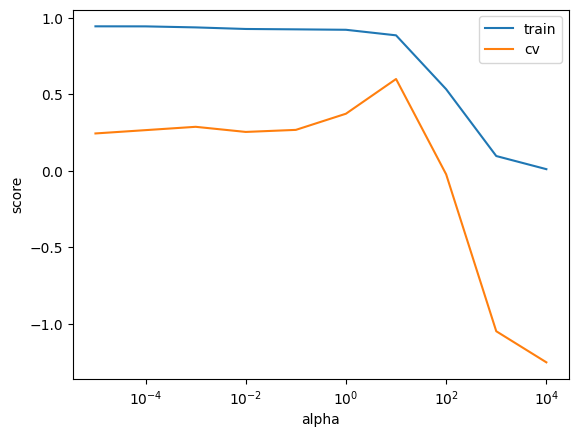

In [21]:
plt.semilogx(alphas, train_scores, label="train")
plt.semilogx(alphas, cv_scores, label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");

In [22]:
# get best alpha
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

10.0

## RidgeCV

In [27]:
# using RidgeCV - tune alpha within Ridge, also confirm best alpha
ridgecv_pipe = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=10))
ridgecv_pipe.fit(X_train, y_train);

In [28]:
best_alpha = ridgecv_pipe.named_steps['ridgecv'].alpha_
best_alpha

10.0

## Coefficients & Intercept

In [12]:
pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
pipe_ridge.fit(X_train, y_train)
coeffs = pipe_ridge.named_steps["ridge"].coef_

In [14]:
pd.DataFrame(data=coeffs, index=X.columns, columns=["Coefficients"])

,Coefficients
e_off_rating,3.189745
e_def_rating,-2.260774
e_net_rating,3.104867
e_pace,-0.445506
e_ast_ratio,1.604573
e_oreb_pct,0.482746
e_dreb_pct,0.244972
e_reb_pct,-0.003913
e_tm_tov_pct,-0.515789
